In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 15.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import json
import shutil
import cv2

# Paths
IMAGE_DIR = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"
ANNOTATION_DIR = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/annotations"
DATASET_DIR = "/kaggle/working/tick_dataset"

# Create dataset structure
for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATASET_DIR, folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, folder, "labels"), exist_ok=True)

# List annotation files
json_files = sorted(os.listdir(ANNOTATION_DIR))

# Train/val/test split
train_split = int(0.8 * len(json_files))
val_split = int(0.9 * len(json_files))

train_files = json_files[:train_split]
val_files = json_files[train_split:val_split]
test_files = json_files[val_split:]

def convert_to_yolo(image_w, image_h, x, y, tick_size=10):
    """
    Convert tick (x, y) positions into YOLO format.
    tick_size: Creates a small bounding box around the tick.
    """
    x_center = x / image_w
    y_center = y / image_h
    w = tick_size / image_w  # Small width
    h = tick_size / image_h  # Small height
    return x_center, y_center, w, h

def process_annotations(json_file, split):
    """Convert JSON annotations to YOLO format."""
    json_path = os.path.join(ANNOTATION_DIR, json_file)
    image_path = os.path.join(IMAGE_DIR, json_file.replace(".json", ".jpg"))

    if not os.path.exists(image_path):
        return

    # Load JSON
    with open(json_path, "r") as f:
        data = json.load(f)

    img = cv2.imread(image_path)
    img_h, img_w, _ = img.shape

    label_txt = ""

    # Extract tick positions
    tick_positions = {}

    if "axes" in data:
        if "x-axis" in data["axes"] and "ticks" in data["axes"]["x-axis"]:
            tick_positions.update({tick["id"]: (tick["tick_pt"]["x"], tick["tick_pt"]["y"]) for tick in data["axes"]["x-axis"]["ticks"]})
        
        if "y-axis" in data["axes"] and "ticks" in data["axes"]["y-axis"]:
            tick_positions.update({tick["id"]: (tick["tick_pt"]["x"], tick["tick_pt"]["y"]) for tick in data["axes"]["y-axis"]["ticks"]})

    # Extract tick labels from "text"
    for text_item in data.get("text", []):
        if text_item["role"] == "tick_label":
            tick_id = text_item["id"]
            
            # Find corresponding tick position
            if tick_id in tick_positions:
                x, y = tick_positions[tick_id]

                # Convert to YOLO format
                x_n, y_n, w_n, h_n = convert_to_yolo(img_w, img_h, x, y)

                # Class 0 = x-tick, Class 1 = y-tick
                tick_class = 0 if x > y else 1  
                label_txt += f"{tick_class} {x_n} {y_n} {w_n} {h_n}\n"

    # Save label file if ticks exist
    if label_txt:
        split_folder = os.path.join(DATASET_DIR, split)
        shutil.copy(image_path, os.path.join(split_folder, "images", json_file.replace(".json", ".jpg")))
        with open(os.path.join(split_folder, "labels", json_file.replace(".json", ".txt")), "w") as f:
            f.write(label_txt)

# Convert all JSON files
for split, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
    for json_file in files:
        process_annotations(json_file, split)

print("✅ Fixed Dataset Conversion Completed!")

✅ Fixed Dataset Conversion Completed!


In [ ]:
import os
import json
import shutil
import cv2

# Paths
IMAGE_DIR = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"
ANNOTATION_DIR = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/annotations"
DATASET_DIR = "/kaggle/working/tick_dataset"

# Create dataset structure
for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATASET_DIR, folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, folder, "labels"), exist_ok=True)

# List annotation files
json_files = sorted(os.listdir(ANNOTATION_DIR))

# Train/val/test split
train_split = int(0.8 * len(json_files))
val_split = int(0.9 * len(json_files))

train_files = json_files[:train_split]
val_files = json_files[train_split:val_split]
test_files = json_files[val_split:]

def convert_to_yolo(image_w, image_h, x, y, tick_size=5):
    """
    Convert tick (x, y) positions into YOLO format.
    tick_size: Creates a small bounding box around the tick.
    """
    x_center = x / image_w
    y_center = y / image_h
    w = tick_size / image_w  # Small width
    h = tick_size / image_h  # Small height
    return x_center, y_center, w, h

def convert_to_yolo2(image_w, image_h, x, y, w, h):
    """
    Convert (x, y, w, h) positions into YOLO format.
    """
    x_center = (x + w / 2) / image_w
    y_center = (y + h / 2) / image_h
    w = w / image_w
    h = h / image_h
    return x_center, y_center, w, h

def process_annotations(json_file, split):
    """Convert JSON annotations to YOLO format."""
    json_path = os.path.join(ANNOTATION_DIR, json_file)
    image_path = os.path.join(IMAGE_DIR, json_file.replace(".json", ".jpg"))

    if not os.path.exists(image_path):
        return

    # Load JSON
    with open(json_path, "r") as f:
        data = json.load(f)

    img = cv2.imread(image_path)
    img_h, img_w, _ = img.shape

    label_txt = ""

    # Extract tick positions
    tick_positions = {}
    x_tick_ids = set()
    y_tick_ids = set()
    
    if "axes" in data:
        if "x-axis" in data["axes"] and "ticks" in data["axes"]["x-axis"]:
            for tick in data["axes"]["x-axis"]["ticks"]:
                tick_positions[tick["id"]] = (tick["tick_pt"]["x"], tick["tick_pt"]["y"])
                x_tick_ids.add(tick["id"])
        
        if "y-axis" in data["axes"] and "ticks" in data["axes"]["y-axis"]:
            for tick in data["axes"]["y-axis"]["ticks"]:
                tick_positions[tick["id"]] = (tick["tick_pt"]["x"], tick["tick_pt"]["y"])
                y_tick_ids.add(tick["id"])

    # Extract tick labels from "text"
    for text_item in data.get("text", []):
        if text_item["role"] == "tick_label":
            tick_id = text_item["id"]
            
            # Find corresponding tick position
            if tick_id in tick_positions:
                x, y = tick_positions[tick_id]

                # Convert to YOLO format
                x_n, y_n, w_n, h_n = convert_to_yolo(img_w, img_h, x, y)

                if tick_id in x_tick_ids:
                    tick_class = 0
                elif tick_id in y_tick_ids:
                    tick_class = 1
                else:
                    continue
                label_txt += f"{tick_class} {x_n} {y_n} {w_n} {h_n}\n"

    for text_item in data.get("text", []):
        if text_item["role"] == "tick_label":
            poly = text_item["polygon"]
            x0, y0 = poly["x0"], poly["y0"]
            x1, y1 = poly["x1"], poly["y1"]
            x2, y2 = poly["x2"], poly["y2"]
            x3, y3 = poly["x3"], poly["y3"]

            # Compute bounding box
            x_min, x_max = min(x0, x1, x2, x3), max(x0, x1, x2, x3)
            y_min, y_max = min(y0, y1, y2, y3), max(y0, y1, y2, y3)
            w, h = x_max - x_min, y_max - y_min

            # Convert to YOLO format
            x_n, y_n, w_n, h_n = convert_to_yolo2(img_w, img_h, x_min, y_min, w, h)

            if text_item["id"] in x_tick_ids:
                text_class = 2
            elif text_item["id"] in y_tick_ids:
                text_class = 3
            else:
                continue
            
            # Class 2 = text box
            label_txt += f"{text_class} {x_n} {y_n} {w_n} {h_n}\n"
    
    # Save label file if ticks exist
    if label_txt:
        split_folder = os.path.join(DATASET_DIR, split)
        shutil.copy(image_path, os.path.join(split_folder, "images", json_file.replace(".json", ".jpg")))
        with open(os.path.join(split_folder, "labels", json_file.replace(".json", ".txt")), "w") as f:
            f.write(label_txt)

# Convert all JSON files
for split, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
    for json_file in files:
        process_annotations(json_file, split)

print("✅ Fixed Dataset Conversion Completed!")

In [9]:
import os
import json
import shutil
import cv2

# Paths
IMAGE_DIR = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"
ANNOTATION_DIR = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/annotations"
DATASET_DIR = "/kaggle/working/tick_dataset"

# Create dataset structure
for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATASET_DIR, folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, folder, "labels"), exist_ok=True)

# List annotation files
json_files = sorted(os.listdir(ANNOTATION_DIR))

# Train/val/test split
train_split = int(0.8 * len(json_files))
val_split = int(0.9 * len(json_files))

train_files = json_files[:train_split]
val_files = json_files[train_split:val_split]
test_files = json_files[val_split:]

def convert_to_yolo(image_w, image_h, x, y, tick_size=5):
    """
    Convert tick (x, y) positions into YOLO format.
    tick_size: Creates a small bounding box around the tick.
    """
    x_center = x / image_w
    y_center = y / image_h
    w = tick_size / image_w  # Small width
    h = tick_size / image_h  # Small height
    return x_center, y_center, w, h

def convert_to_yolo2(image_w, image_h, x, y, w, h):
    """
    Convert (x, y, w, h) positions into YOLO format.
    """
    x_center = (x + w / 2) / image_w
    y_center = (y + h / 2) / image_h
    w = w / image_w
    h = h / image_h
    return x_center, y_center, w, h

def process_annotations(json_file, split):
    """Convert JSON annotations to YOLO format."""
    json_path = os.path.join(ANNOTATION_DIR, json_file)
    image_path = os.path.join(IMAGE_DIR, json_file.replace(".json", ".jpg"))

    if not os.path.exists(image_path):
        return

    # Load JSON
    with open(json_path, "r") as f:
        data = json.load(f)

    img = cv2.imread(image_path)
    img_h, img_w, _ = img.shape

    label_txt = ""
    seen_labels = set()  # **🔹 Store unique labels to prevent duplicates**

    # Extract tick positions
    tick_positions = {}
    x_tick_ids = set()
    y_tick_ids = set()
    
    if "axes" in data:
        if "x-axis" in data["axes"] and "ticks" in data["axes"]["x-axis"]:
            for tick in data["axes"]["x-axis"]["ticks"]:
                tick_positions[tick["id"]] = (tick["tick_pt"]["x"], tick["tick_pt"]["y"])
                x_tick_ids.add(tick["id"])
        
        if "y-axis" in data["axes"] and "ticks" in data["axes"]["y-axis"]:
            for tick in data["axes"]["y-axis"]["ticks"]:
                tick_positions[tick["id"]] = (tick["tick_pt"]["x"], tick["tick_pt"]["y"])
                y_tick_ids.add(tick["id"])

    # Extract tick labels from "text"
    for text_item in data.get("text", []):
        if text_item["role"] == "tick_label":
            tick_id = text_item["id"]
            
            # Find corresponding tick position
            if tick_id in tick_positions:
                x, y = tick_positions[tick_id]
                x_n, y_n, w_n, h_n = convert_to_yolo(img_w, img_h, x, y)

                if ((tick_id in x_tick_ids) and (tick_id in y_tick_ids)):
                    tick_class = 4
                elif tick_id in x_tick_ids:
                    tick_class = 0
                elif tick_id in y_tick_ids:
                    tick_class = 1
                else:
                    continue
                
                label_entry = (tick_class, x_n, y_n, w_n, h_n)  # **Create a unique tuple**
                if label_entry not in seen_labels:  # ** Only add if not a duplicate**
                    seen_labels.add(label_entry)
                    label_txt += f"{tick_class} {x_n} {y_n} {w_n} {h_n}\n"

    # Process text box positions
    for text_item in data.get("text", []):
        if text_item["role"] == "tick_label":
            poly = text_item["polygon"]
            x0, y0 = poly["x0"], poly["y0"]
            x1, y1 = poly["x1"], poly["y1"]
            x2, y2 = poly["x2"], poly["y2"]
            x3, y3 = poly["x3"], poly["y3"]

            # Compute bounding box
            x_min, x_max = min(x0, x1, x2, x3), max(x0, x1, x2, x3)
            y_min, y_max = min(y0, y1, y2, y3), max(y0, y1, y2, y3)
            w, h = x_max - x_min, y_max - y_min

            # Convert to YOLO format
            x_n, y_n, w_n, h_n = convert_to_yolo2(img_w, img_h, x_min, y_min, w, h)

            if text_item["id"] in x_tick_ids:
                text_class = 2
            elif text_item["id"] in y_tick_ids:
                text_class = 3
            else:
                continue

            label_entry = (text_class, x_n, y_n, w_n, h_n)  # **Create a unique tuple**
            if label_entry not in seen_labels:  # **🔹 Only add if not a duplicate**
                seen_labels.add(label_entry)
                label_txt += f"{text_class} {x_n} {y_n} {w_n} {h_n}\n"
    
    # Save label file if ticks exist
    if label_txt:
        split_folder = os.path.join(DATASET_DIR, split)
        shutil.copy(image_path, os.path.join(split_folder, "images", json_file.replace(".json", ".jpg")))
        with open(os.path.join(split_folder, "labels", json_file.replace(".json", ".txt")), "w") as f:
            f.write(label_txt)


# Convert all JSON files
for split, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
    for json_file in files:
        process_annotations(json_file, split)

print("✅ Fixed Dataset Conversion Completed!")

✅ Fixed Dataset Conversion Completed!


In [5]:
import os
import json
import shutil
import cv2

# Paths
IMAGE_DIR = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"
ANNOTATION_DIR = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/annotations"
DATASET_DIR = "/kaggle/working/tick_dataset"

# Create dataset structure
for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATASET_DIR, folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, folder, "labels"), exist_ok=True)

# List annotation files
json_files = sorted(os.listdir(ANNOTATION_DIR))

# Train/val/test split
train_split = int(0.8 * len(json_files))
val_split = int(0.9 * len(json_files))

train_files = json_files[:train_split]
val_files = json_files[train_split:val_split]
test_files = json_files[val_split:]

def convert_to_yolo(image_w, image_h, x, y, tick_size=5):
    """Convert tick (x, y) positions into YOLO format."""
    x_center = x / image_w
    y_center = y / image_h
    w = tick_size / image_w
    h = tick_size / image_h
    return x_center, y_center, w, h

def process_annotations(json_file, split):
    """Convert JSON annotations to YOLO format."""
    json_path = os.path.join(ANNOTATION_DIR, json_file)
    image_path = os.path.join(IMAGE_DIR, json_file.replace(".json", ".jpg"))

    if not os.path.exists(image_path):
        return

    # Load JSON
    with open(json_path, "r") as f:
        data = json.load(f)

    img = cv2.imread(image_path)
    img_h, img_w, _ = img.shape

    label_txt = ""
    seen_labels = set()
    tick_positions = {}  # Store (x, y) positions to check for overlaps

    # Extract x-axis and y-axis tick positions
    tick_positions_x = {}
    tick_positions_y = {}

    if "axes" in data:
        if "x-axis" in data["axes"] and "ticks" in data["axes"]["x-axis"]:
            for tick in data["axes"]["x-axis"]["ticks"]:
                tick_positions_x[tick["id"]] = (tick["tick_pt"]["x"], tick["tick_pt"]["y"])

        if "y-axis" in data["axes"] and "ticks" in data["axes"]["y-axis"]:
            for tick in data["axes"]["y-axis"]["ticks"]:
                tick_positions_y[tick["id"]] = (tick["tick_pt"]["x"], tick["tick_pt"]["y"])

    # Convert x-axis ticks and store their positions
    for tick_id, (x, y) in tick_positions_x.items():
        if (x, y) in tick_positions:
            tick_class = 4  # Overlapping tick (both x and y)
        else:
            tick_class = 0  # X-Tick
            tick_positions[(x, y)] = tick_class  # Store tick location

        x_n, y_n, w_n, h_n = convert_to_yolo(img_w, img_h, x, y)
        label_entry = (tick_class, x_n, y_n, w_n, h_n)
        if label_entry not in seen_labels:
            seen_labels.add(label_entry)
            label_txt += f"{tick_class} {x_n} {y_n} {w_n} {h_n}\n"

    # Convert y-axis ticks and store their positions
    for tick_id, (x, y) in tick_positions_y.items():
        if (x, y) in tick_positions:
            tick_class = 4  # Overlapping tick (both x and y)
        else:
            tick_class = 1  # Y-Tick
            tick_positions[(x, y)] = tick_class  # Store tick location

        x_n, y_n, w_n, h_n = convert_to_yolo(img_w, img_h, x, y)
        label_entry = (tick_class, x_n, y_n, w_n, h_n)
        if label_entry not in seen_labels:
            seen_labels.add(label_entry)
            label_txt += f"{tick_class} {x_n} {y_n} {w_n} {h_n}\n"

    # Save label file if ticks exist
    if label_txt:
        split_folder = os.path.join(DATASET_DIR, split)
        shutil.copy(image_path, os.path.join(split_folder, "images", json_file.replace(".json", ".jpg")))
        with open(os.path.join(split_folder, "labels", json_file.replace(".json", ".txt")), "w") as f:
            f.write(label_txt)


# Convert all JSON files
for split, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
    for json_file in files:
        process_annotations(json_file, split)

print("✅ Fixed Dataset Conversion Completed!")


✅ Fixed Dataset Conversion Completed!


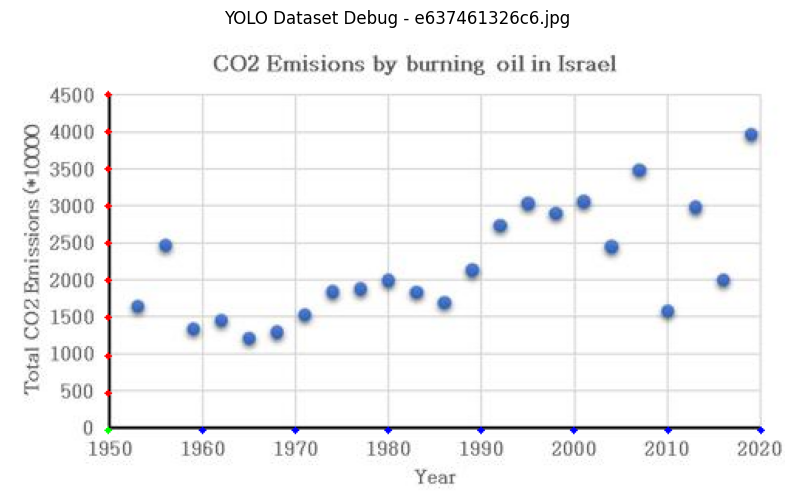

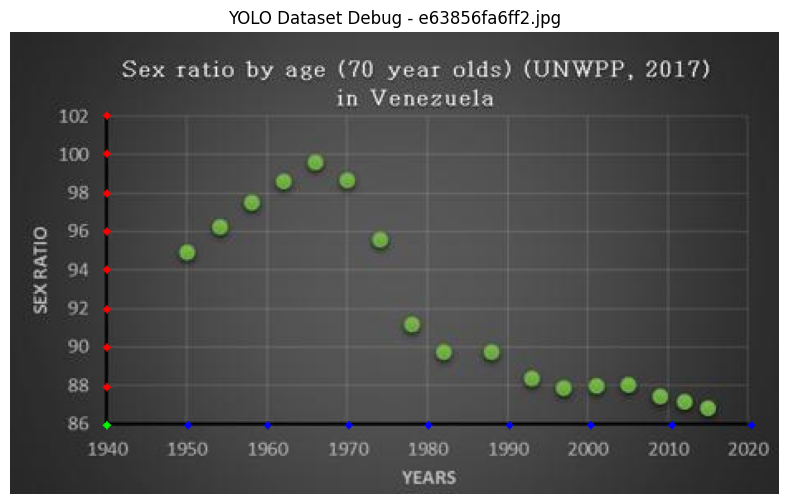

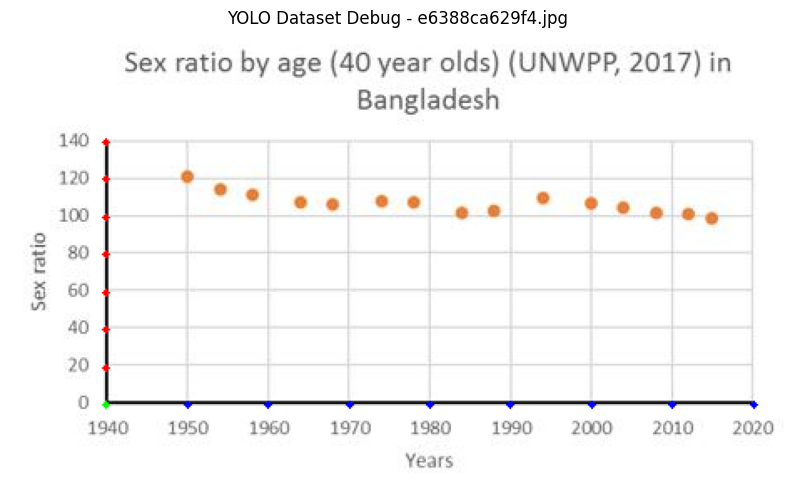

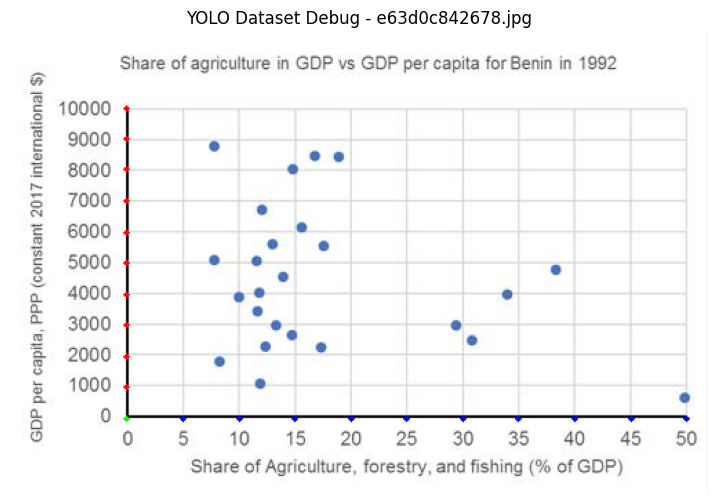

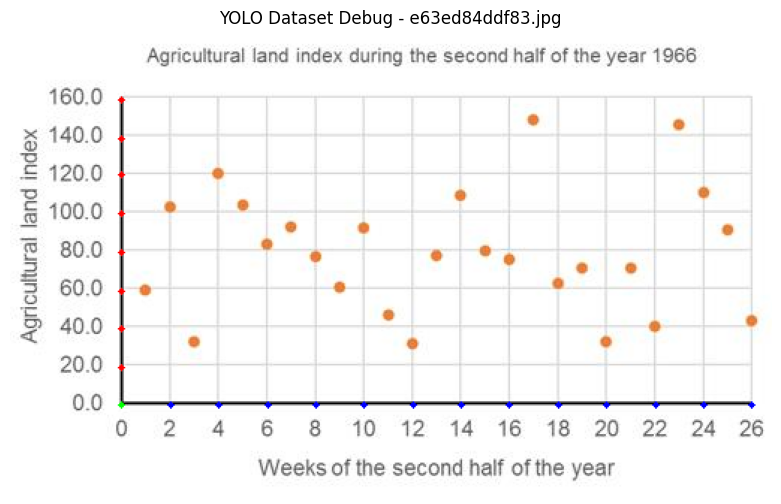

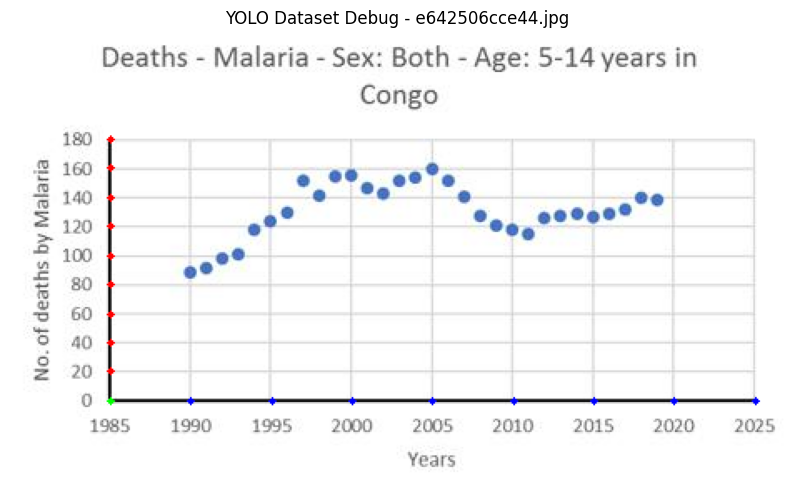

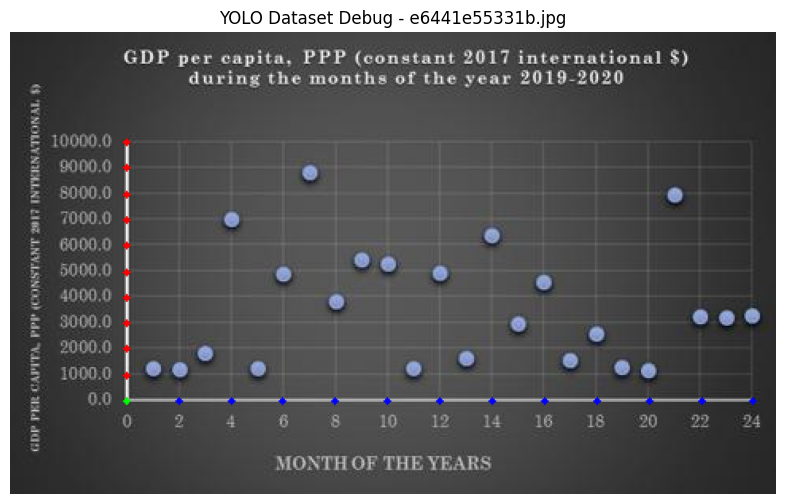

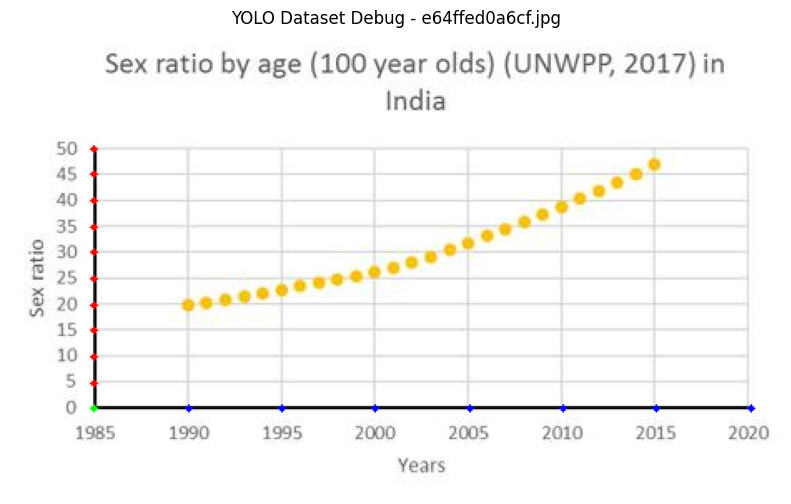

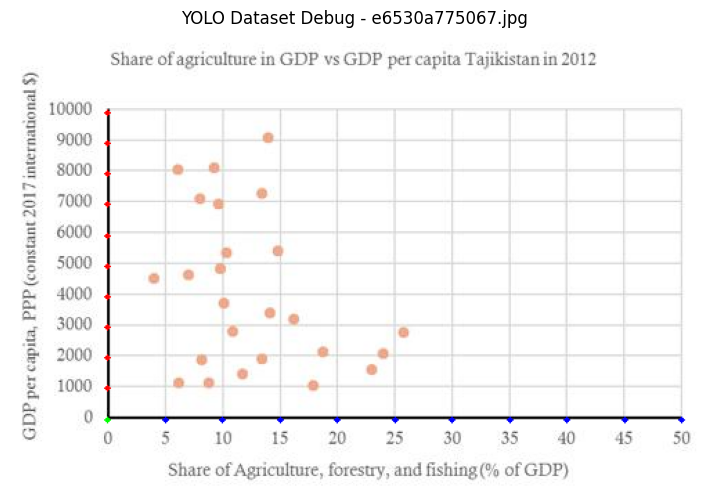

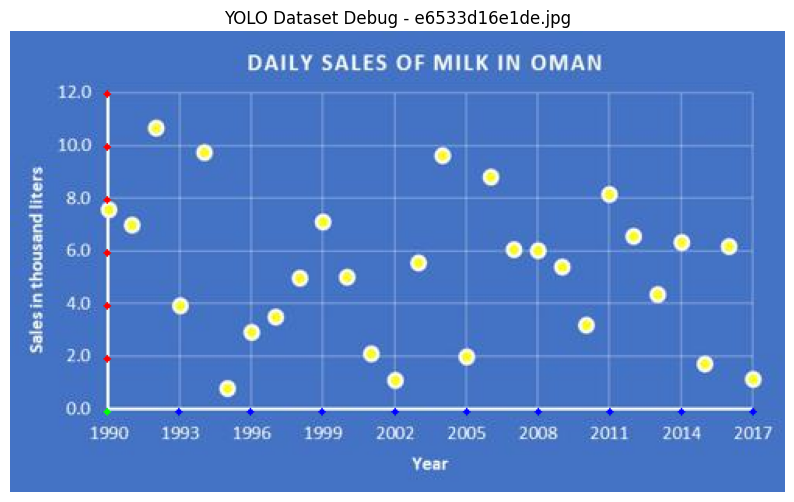

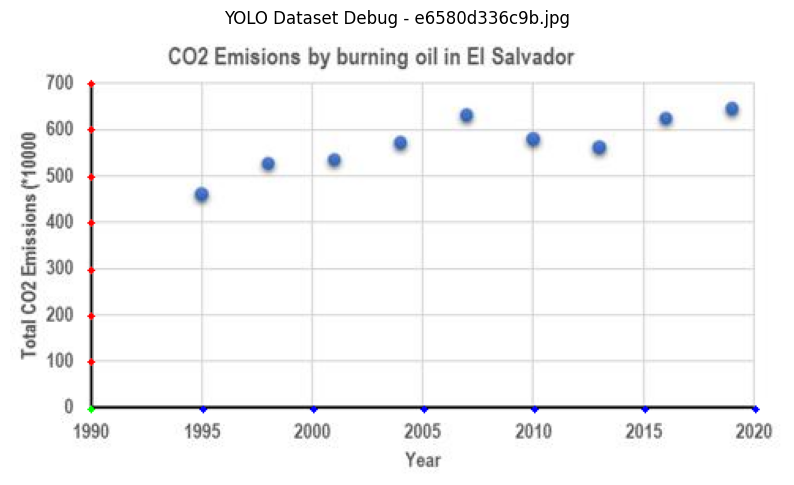

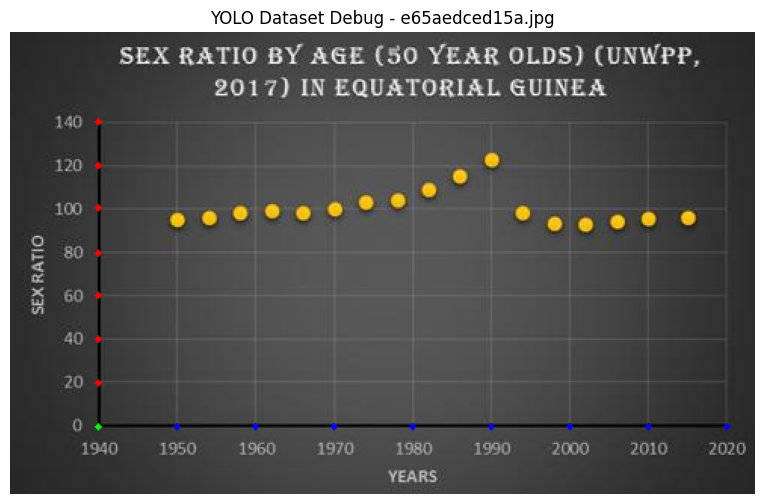

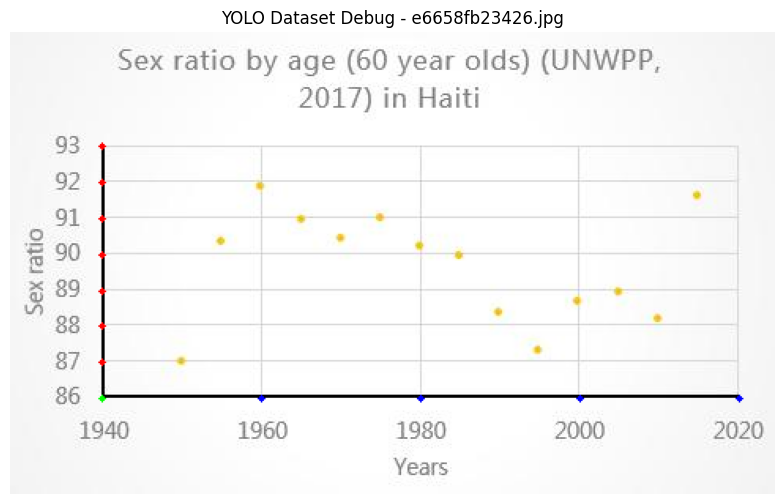

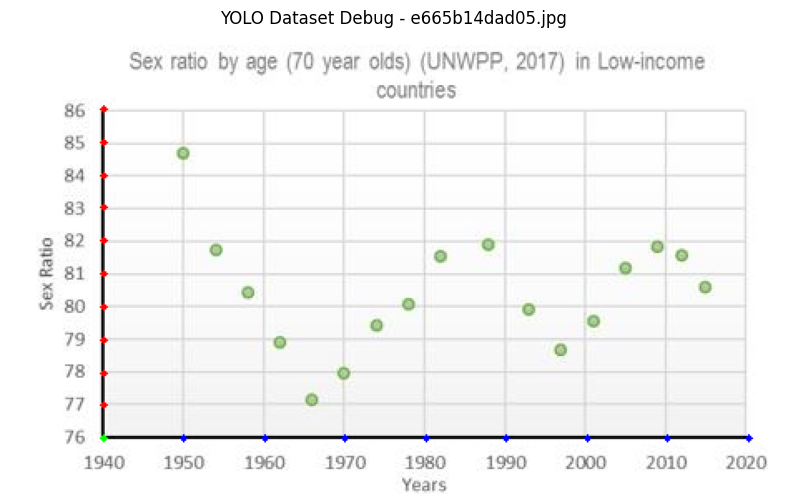

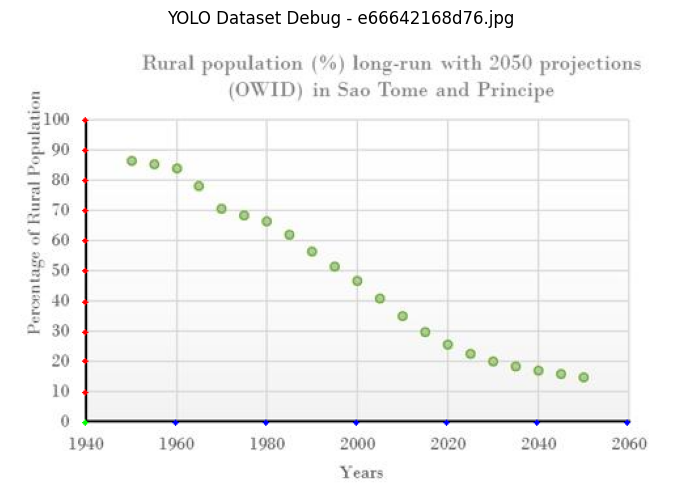

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths to dataset
DATASET_DIR = "/kaggle/working/tick_dataset"
IMAGE_DIR = os.path.join(DATASET_DIR, "test/images")
LABEL_DIR = os.path.join(DATASET_DIR, "test/labels")

# List image and label files
image_files = sorted(os.listdir(IMAGE_DIR))[:15]  # Show first 5 images

for image_file in image_files:
    image_path = os.path.join(IMAGE_DIR, image_file)
    label_path = os.path.join(LABEL_DIR, image_file.replace(".jpg", ".txt"))
    
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Copy for annotation
    annotated_img = img.copy()
    img_h, img_w, _ = img.shape

    # Read YOLO label file
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = f.readlines()
        
        for label in labels:
            parts = label.strip().split()
            class_id = int(parts[0])  # 0 = x-tick, 1 = y-tick, 2 = x-text, 3 = y-text
            x_center, y_center, w, h = map(float, parts[1:])

            # Convert back to pixel coordinates
            x1 = int((x_center - w / 2) * img_w)
            y1 = int((y_center - h / 2) * img_h)
            x2 = int((x_center + w / 2) * img_w)
            y2 = int((y_center + h / 2) * img_h)
            center_x = int(x_center * img_w)
            center_y = int(y_center * img_h)

            # **Draw bounding boxes & points**
            if class_id == 0:  # X-axis tick (Blue)
                cv2.circle(annotated_img, (center_x, center_y), 2, (0, 0, 255), -1)  # Blue circle
            elif class_id == 1:  # Y-axis tick (Red)
                cv2.circle(annotated_img, (center_x, center_y), 2, (255, 0, 0), -1)  # Red circle
            elif class_id == 2:  # X-axis text box (Blue box)
                cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Blue box
            elif class_id == 3:  # Y-axis text box (Red box)
                cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red box
            elif class_id == 4:  # XY-axis tick (Green)
                cv2.circle(annotated_img, (center_x, center_y), 2, (0, 255, 0), -1)  # Green circle

    # **Display annotated image**
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(annotated_img)
    ax.set_title(f"YOLO Dataset Debug - {image_file}")
    ax.axis("off")
    plt.show()


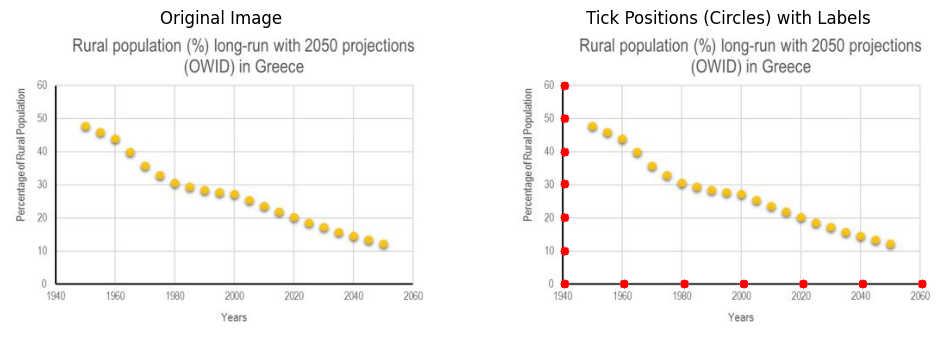

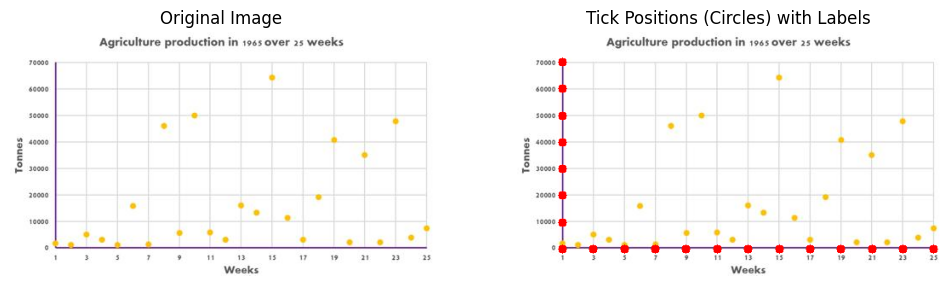

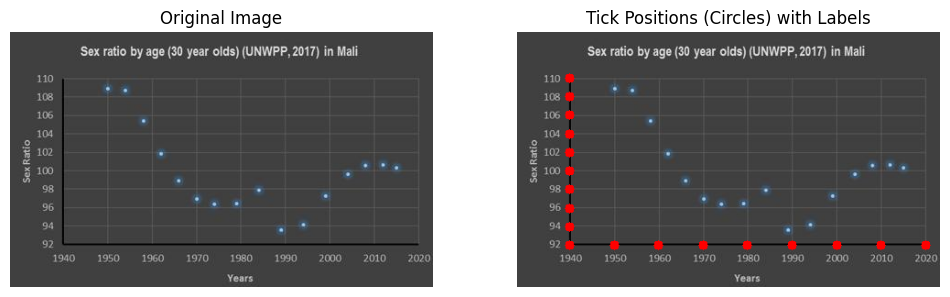

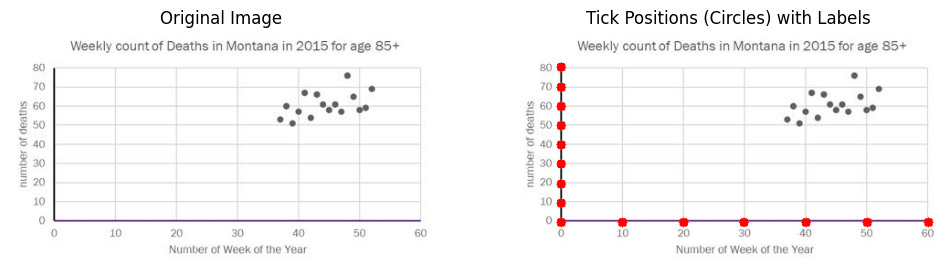

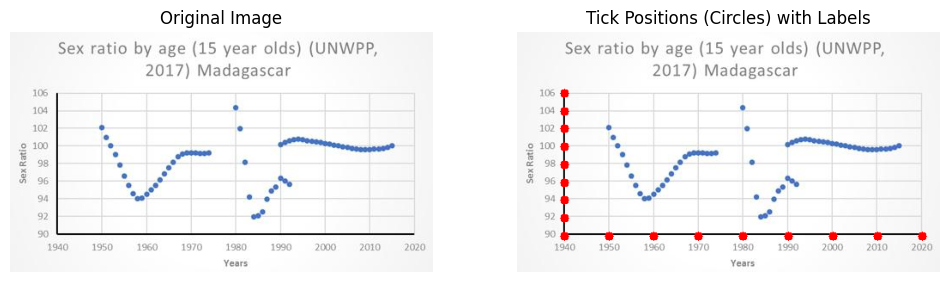

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths to dataset
DATASET_DIR = "/kaggle/working/tick_dataset"
IMAGE_DIR = os.path.join(DATASET_DIR, "train/images")
LABEL_DIR = os.path.join(DATASET_DIR, "train/labels")

# List image and label files
image_files = sorted(os.listdir(IMAGE_DIR))

# Visualize first 5 images
for image_file in image_files[:5]:
    image_path = os.path.join(IMAGE_DIR, image_file)
    label_path = os.path.join(LABEL_DIR, image_file.replace(".jpg", ".txt"))
    
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Copy for annotation
    annotated_img = img.copy()

    img_h, img_w, _ = img.shape

    # Read YOLO label file
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = f.readlines()
        
        for label in labels:
            parts = label.strip().split()
            tick_class = int(parts[0])  # 0 for x-axis tick, 1 for y-axis tick
            x_center, y_center, w, h = map(float, parts[1:5])
            tick_text = " ".join(parts[5:])  # Extract text from label file

            # Convert back to pixel coordinates
            x = int(x_center * img_w)
            y = int(y_center * img_h)
            w = int(w * img_w)
            h = int(h * img_h)

            # Draw a circle at the tick position
            cv2.circle(annotated_img, (x, y), 5, (255, 0, 0), -1)  # Red circle
            
            # Display the tick text near it
            cv2.putText(annotated_img, tick_text, (x + w // 2, y - h // 2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

    # Display original vs annotated image
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(annotated_img)
    axes[1].set_title("Tick Positions (Circles) with Labels")
    axes[1].axis("off")

    plt.show()


In [8]:
yaml_content = """\
path: /kaggle/working/tick_dataset
train: train/images
val: val/images
test: test/images

nc: 5
names: ["x-tick", "y-tick", "x-tick-text", "y-tick-text", "xy-tick"]
"""

with open("/kaggle/working/tick_dataset/dataset.yaml", "w") as f:
    f.write(yaml_content)

print("✅ dataset.yaml updated with text box class.")


✅ dataset.yaml updated with text box class.


In [19]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8x.pt")  # Pretrained YOLOv8 model

# Train YOLO
model.train(
    data="/kaggle/working/tick_dataset/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    project="/kaggle/working/runs",
    name="tick_train"
)

print("✅ Training completed.")

Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/tick_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/runs, name=tick_train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

100%|██████████| 755k/755k [00:00<00:00, 46.3MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 157MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/tick_dataset/train/labels... 8989 images, 0 backgrounds, 1 corrupt: 100%|██████████| 8989/8989 [00:08<00:00, 1101.96it/s]

train: WARNING ⚠️ /kaggle/working/tick_dataset/train/images/3ef41bbc82c3.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     3.2812      3.2812      1.1927      3.2812       1.546      3.2812      1.9015      3.2812       2.257      3.2812      2.6124      3.2812      2.9657      3.2812      3.3212      3.2812      3.6767      3.2812      4.0321      3.2812      1.2109      1.5039      1.8008      2.0977      2.3945      2.6875
      2.9844      3.2812]


train: New cache created: /kaggle/working/tick_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/tick_dataset/val/labels... 1123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1123/1123 [00:01<00:00, 695.88it/s]


val: New cache created: /kaggle/working/tick_dataset/val/labels.cache
Plotting labels to /kaggle/working/runs/tick_train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tick_train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        15G      2.741      5.271     0.8592        312        640: 100%|██████████| 562/562 [12:47<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


                   all       1123      20163      0.745      0.433      0.389      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.4G      2.513      1.146     0.8193        511        640:   2%|▏         | 14/562 [00:19<12:39,  1.39s/it]


KeyboardInterrupt: 

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load trained model
model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")

# Paths
DATASET_DIR = "/kaggle/working/tick_dataset"
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "test/images")

# Test images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))[:5]

for img_file in test_images:
    img_path = os.path.join(TEST_IMAGES_DIR, img_file)

    # Run YOLO inference
    results = model(img_path)

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw detections
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])  # Get class (0=x-tick, 1=y-tick, 2=text box)
        
        if class_id in [0, 1]:  # Tick points
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            cv2.circle(image, (center_x, center_y), 5, (255, 0, 0), -1)  # Red circle for ticks
        
        elif class_id == 2:  # Text bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green bounding box for text

    # Show result
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted Ticks & Text - {img_file}")
    plt.axis("off")
    plt.show()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/tick_train/weights/best.pt'

In [10]:
import matplotlib.pyplot as plt

# Load trained model
model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")

# Test images
test_images = sorted(os.listdir(os.path.join(DATASET_DIR, "test/images")))[:5]

for img_file in test_images:
    img_path = os.path.join(DATASET_DIR, "test/images", img_file)

    # Run YOLO inference
    results = model(img_path)

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw detected ticks
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        cv2.circle(image, (center_x, center_y), 5, (255, 0, 0), -1)  # Draw tick point

    # Show result
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted Ticks - {img_file}")
    plt.axis("off")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/tick_train/weights/best.pt'

In [11]:
!pip install transformers datasets torchvision torch

In [12]:
# Load Processor & Model with Local Cache
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# If you want to start from the pretrained model, load the checkpoint with `VisionEncoderDecoderModel`
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')

# TrOCR is a decoder model and should be used within a VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
import torch

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("✅ TrOCR Model Loaded Successfully")

✅ TrOCR Model Loaded Successfully


In [14]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Load YOLO model
from ultralytics import YOLO
yolo_model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")

# Paths
DATASET_DIR = "/kaggle/working/tick_dataset"
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "test/images")

# Get test images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))[:5]

for img_file in test_images:
    img_path = os.path.join(TEST_IMAGES_DIR, img_file)

    # Run YOLO inference
    results = yolo_model(img_path)

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Copy for visualization
    annotated_img = image.copy()

    # Process YOLO predictions
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=text box

        if class_id == 2:  # If it's a text box
            # Crop the text region
            cropped_text = image[y1:y2, x1:x2]

            # Convert to PIL Image
            pil_image = Image.fromarray(cropped_text)

            # Process for TrOCR
            pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)

            # Predict text
            generated_ids = model.generate(pixel_values)
            predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            # Draw bounding box & recognized text
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(annotated_img, predicted_text, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
        if class_id == 3:  # If it's a text box
            # Crop the text region
            cropped_text = image[y1:y2, x1:x2]

            # Convert to PIL Image
            pil_image = Image.fromarray(cropped_text)

            # Process for TrOCR
            pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)

            # Predict text
            generated_ids = model.generate(pixel_values)
            predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            # Draw bounding box & recognized text
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Green box
            cv2.putText(annotated_img, predicted_text, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)

        if class_id == 0:
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            cv2.circle(annotated_img, (center_x, center_y), 5, (0, 255, 0), -1)  # Draw tick point

        if class_id == 1:
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            cv2.circle(annotated_img, (center_x, center_y), 5, (0, 0, 255), -1)  # Draw tick point

    # Display results
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(annotated_img)
    ax.set_title(f"YOLO + TrOCR Predictions - {img_file}")
    ax.axis("off")
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/tick_train/weights/best.pt'

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load YOLO model
tick_model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")  # Detects ticks & text boxes

# Load TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model.to(device)

# Paths
DATASET_DIR = "/kaggle/working/tick_dataset"
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "test/images")

# Get test images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))[:5]

for img_file in test_images:
    img_path = os.path.join(TEST_IMAGES_DIR, img_file)

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape

    # Run YOLO inference for ticks
    tick_results = tick_model(img_path)

    # Store detected elements
    tick_positions_x = []  # X-axis tick positions
    tick_positions_y = []  # Y-axis tick positions

    # Text box positions & recognized values
    text_boxes_x = []  # X-axis text positions
    text_boxes_y = []  # Y-axis text positions
    recognized_texts_x = []  # Recognized X-axis tick values
    recognized_texts_y = []  # Recognized Y-axis tick values

    # Detect elements
    for box in tick_results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=x-text, 3=y-text

        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        if class_id in [2, 3]:  # If it's a text box, recognize text
            cropped_text = image[y1:y2, x1:x2]
            pil_image = Image.fromarray(cropped_text)

            # Process for TrOCR
            pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)

            # Predict text
            with torch.no_grad():
                generated_ids = text_model.generate(pixel_values)
                predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            try:
                plot_value = float(predicted_text)  # Convert to float
                if class_id == 2:  # X-axis text
                    text_boxes_x.append((center_x, center_y, plot_value))
                elif class_id == 3:  # Y-axis text
                    text_boxes_y.append((center_x, center_y, plot_value))
            except ValueError:
                continue  # Skip invalid text values

        elif class_id == 0:  # X-axis tick
            tick_positions_x.append((center_x, center_y))
        elif class_id == 1:  # Y-axis tick
            tick_positions_y.append((center_x, center_y))

    # **Sort tick positions**
    text_boxes_x.sort(key=lambda t: t[0])  # X-text: Left → Right
    text_boxes_y.sort(key=lambda t: t[1], reverse=True)  # Y-text: Bottom → Top
    tick_positions_x.sort(key=lambda t: t[0])  # X-ticks: Left → Right
    tick_positions_y.sort(key=lambda t: t[1], reverse=True)  # Y-ticks: Bottom → Top

    # **Print detected values**
    print(f"\n📌 Image: {img_file}")
    print("=" * 50)

    print("\n📍 **Y-axis Tick Positions (image space - x,y values):**")
    for (x, y) in tick_positions_y:
        print(f"  - Tick at ({x}, {y})")

    print("\n📌 **Y-axis Text Boxes (Detected text & position):**")
    for (x, y, text) in text_boxes_y:
        print(f"  - Text: {text} at center ({x}, {y})")

    print("\n📍 **X-axis Tick Positions (image space - x,y values):**")
    for (x, y) in tick_positions_x:
        print(f"  - Tick at ({x}, {y})")

    print("\n📌 **X-axis Text Boxes (Detected text & position):**")
    for (x, y, text) in text_boxes_x:
        print(f"  - Text: {text} at center ({x}, {y})")

    print("=" * 50)

    # **Display Results**
    annotated_img = image.copy()

    # Draw tick points
    for (x, y) in tick_positions_x:
        cv2.circle(annotated_img, (x, y), 5, (255, 0, 0), -1)  # Blue for X-ticks
    for (x, y) in tick_positions_y:
        cv2.circle(annotated_img, (x, y), 5, (0, 0, 255), -1)  # Red for Y-ticks

    # Draw text boxes
    for (x, y, text) in text_boxes_x:
        cv2.putText(annotated_img, str(text), (x - 10, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    for (x, y, text) in text_boxes_y:
        cv2.putText(annotated_img, str(text), (x - 10, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 165, 0), 2)

    # Show results
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(annotated_img)
    ax.set_title(f"YOLO + TrOCR Predictions - {img_file}")
    ax.axis("off")
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/tick_train/weights/best.pt'

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load YOLO model for ticks and text boxes
tick_model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")

# Load TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model.to(device)

# Paths
DATASET_DIR = "/kaggle/working/tick_dataset"
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "test/images")

# Get test images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))[:5]

for img_file in test_images:
    img_path = os.path.join(TEST_IMAGES_DIR, img_file)

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated_img = image.copy()  # Copy for visualization
    img_h, img_w, _ = image.shape

    # Run YOLO inference for ticks
    tick_results = tick_model(img_path)

    # Store detected elements
    tick_positions_x = []  # (x_img, x_plot)
    tick_positions_y = []  # (y_img, y_plot)
    y_tick_positions = []  # To track the lowest y-tick position
    duplicate_x_tick = None  # Placeholder for the duplicate X-axis tick

    # Text box positions & recognized values
    text_boxes_x = []  # X-axis text positions
    text_boxes_y = []  # Y-axis text positions
    recognized_texts_x = []  # Recognized X-axis tick values
    recognized_texts_y = []  # Recognized Y-axis tick values

    # Process YOLO predictions
    for box in tick_results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=x-text, 3=y-text

        if class_id == 1:  # Y-axis tick
            y_tick_positions.append((x1, y1, x2, y2))  # Store all Y-tick positions

        if class_id in [2, 3]:  # If it's a text box, recognize text
            cropped_text = image[y1:y2, x1:x2]
            pil_image = Image.fromarray(cropped_text)

            # Process for TrOCR
            pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)

            # Predict text
            with torch.no_grad():
                generated_ids = text_model.generate(pixel_values)
                predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            # Draw text box on image
            color = (0, 255, 0) if class_id == 2 else (0, 0, 255)  # Green for X-text, Red for Y-text
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(annotated_img, predicted_text, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

            if class_id == 2:  # X-axis text
                text_boxes_x.append((x1, y1, x2, y2, predicted_text))
            elif class_id == 3:  # Y-axis text
                text_boxes_y.append((x1, y1, x2, y2, predicted_text))

        elif class_id in [0, 1]:  # Tick marks
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            tick_color = (255, 0, 0)  # Blue for tick points
            cv2.circle(annotated_img, (center_x, center_y), 5, tick_color, -1)  # Draw tick point
            if class_id == 0:  # X-axis tick
                tick_positions_x.append(center_x)
            else:  # Y-axis tick
                tick_positions_y.append(center_y)

    # **Sort tick positions before matching**
    tick_positions_x = sorted(tick_positions_x)  # Sort X-ticks from left to right
    tick_positions_y = sorted(tick_positions_y, reverse=True)  # Sort Y-ticks from bottom to top

    # **Sort text boxes before matching**
    text_boxes_x = sorted(text_boxes_x, key=lambda t: t[0])  # Sort by X-position (left to right)
    text_boxes_y = sorted(text_boxes_y, key=lambda t: t[1], reverse=True)  # Sort by Y-position (bottom to top)

    # **Find the lowest Y-tick (which is also an X-tick)**
    if y_tick_positions:
        min_y_tick = min(y_tick_positions, key=lambda t: t[1])  # Find lowest Y tick
        min_y_tick_x1, min_y_tick_y1, min_y_tick_x2, min_y_tick_y2 = min_y_tick

        # **Find corresponding Y-axis text to use as an X-tick**
        for x1, y1, x2, y2, text in text_boxes_y:
            if min_y_tick_x1 <= x1 <= min_y_tick_x2 and min_y_tick_y1 <= y1 <= min_y_tick_y2:
                duplicate_x_tick = (x1, y1, x2, y2, text)
                break  # Stop after finding first match

    # **If the first X-tick is missing, use the duplicate from Y-axis**
    if duplicate_x_tick and (not text_boxes_x or text_boxes_x[0][0] > duplicate_x_tick[0]):
        text_boxes_x.insert(0, duplicate_x_tick)

    # **Extract tick texts**
    x_text_values = [text for _, _, _, _, text in text_boxes_x]
    y_text_values = [text for _, _, _, _, text in text_boxes_y]

    # Print extracted axis values
    print(f"Image: {img_file}")
    print(f"X-axis Tick Texts: {x_text_values}")
    print(f"Y-axis Tick Texts: {y_text_values}")
    print("=" * 50)

    # Display results
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(annotated_img)
    ax.set_title(f"YOLO + TrOCR Predictions - {img_file}")
    ax.axis("off")
    plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load YOLO models
tick_model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")  # Detects ticks & text boxes
scatter_model = YOLO("/kaggle/input/scatter-point-detection-yolo/other/default/1/best.pt")  # Detects scatter points

# Load TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model.to(device)

# Paths
DATASET_DIR = "/kaggle/working/tick_dataset"
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "test/images")

# Get test images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))[:5]

for img_file in test_images:
    img_path = os.path.join(TEST_IMAGES_DIR, img_file)

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated_img = image.copy()  # Copy for visualization
    img_h, img_w, _ = image.shape

    # Run YOLO inference for ticks
    tick_results = tick_model(img_path)

    # Store detected elements
    tick_positions_x = []  # (image_x, plot_x_value)
    tick_positions_y = []  # (image_y, plot_y_value)

    # Text box positions & recognized values
    text_boxes_x = []  # X-axis text positions
    text_boxes_y = []  # Y-axis text positions
    recognized_texts_x = []  # Recognized X-axis tick values
    recognized_texts_y = []  # Recognized Y-axis tick values

    # Process YOLO predictions
    for box in tick_results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=x-text, 3=y-text

        if class_id in [2, 3]:  # If it's a text box, recognize text
            cropped_text = image[y1:y2, x1:x2]
            pil_image = Image.fromarray(cropped_text)

            # Process for TrOCR
            pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)

            # Predict text
            with torch.no_grad():
                generated_ids = text_model.generate(pixel_values)
                predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            if class_id == 2:  # X-axis text
                text_boxes_x.append((x1, y1, x2, y2, predicted_text))
            elif class_id == 3:  # Y-axis text
                text_boxes_y.append((x1, y1, x2, y2, predicted_text))

        elif class_id in [0, 1]:  # Tick marks
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            if class_id == 0:  # X-axis tick
                tick_positions_x.append((center_x,center_y))
            else:  # Y-axis tick
                tick_positions_y.append((center_x,center_y))

    # **Sort tick positions before matching**
    tick_positions_x = sorted(tick_positions_x, key=lambda t: t[0])  # Sort X-ticks by center_x
    tick_positions_y = sorted(tick_positions_y, key=lambda t: t[1], reverse=True)  # Sort Y-ticks by center_y
    
    # **Insert the first Y-axis tick into X-axis ticks (fix missing first X tick)**
    tick_positions_x.insert(0, tick_positions_y[0])  # First X tick is the bottom-most Y tick
    
    # **Extract only center_x values for x-ticks & center_y values for y-ticks**
    tick_positions_x = [x[0] for x in tick_positions_x]  # Remove center_y from X-ticks
    tick_positions_y = [y[1] for y in tick_positions_y]  # Remove center_x from Y-ticks


    # **Sort text boxes before matching**
    text_boxes_x = sorted(text_boxes_x, key=lambda t: t[0])  # Sort by X-position (left to right)
    text_boxes_y = sorted(text_boxes_y, key=lambda t: t[1], reverse=True)  # Sort by Y-position (bottom to top)

    print(len(tick_positions_x))
    print(len(text_boxes_x))
    print()
    print(len(tick_positions_y))
    print(len(text_boxes_y))

    # **Match text to nearest tick positions**
    def match_ticks_to_text(tick_positions, text_boxes):
        """
        Matches each tick with its nearest text box.
        """
        matched_ticks = []
        for i, tick_pos in enumerate(tick_positions):
            if i < len(text_boxes):
                _, _, _, _, text_value = text_boxes[i]  # Extract text value from box
                try:
                    plot_value = float(text_value)  # Convert to float
                    matched_ticks.append((tick_pos, plot_value))
                except ValueError:
                    continue  # Skip invalid text values

        return matched_ticks

    # Get matched tick values
    x_axis_values = match_ticks_to_text(tick_positions_x, text_boxes_x)
    y_axis_values = match_ticks_to_text(tick_positions_y, text_boxes_y)

    print(x_axis_values)
    print(y_axis_values)

    # Extract only the plot values
    x_img, x_plot = zip(*x_axis_values) if x_axis_values else ([], [])
    y_img, y_plot = zip(*y_axis_values) if y_axis_values else ([], [])

    # **Fit linear transformation for x and y**
    x_transform = np.poly1d(np.polyfit(x_img, x_plot, 1)) if len(x_img) > 1 else lambda x: x
    y_transform = np.poly1d(np.polyfit(y_img, y_plot, 1)) if len(y_img) > 1 else lambda y: y

    # Run YOLO inference for scatter points
    scatter_results = scatter_model(img_path)

    # **Extract scatter positions & transform to plot space**
    scatter_plot_coords = []
    for box in scatter_results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Convert image coordinates to plot coordinates
        plot_x = x_transform(center_x)
        plot_y = y_transform(center_y)

        scatter_plot_coords.append((plot_x, plot_y))

        # Draw scatter point
        cv2.circle(annotated_img, (center_x, center_y), 2, (255, 0, 0), -1)
        cv2.putText(annotated_img, f"({plot_x:.2f}, {plot_y:.2f})", (center_x + 10, center_y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)

    # **Sort scatter points by X-value**
    scatter_plot_coords = sorted(scatter_plot_coords, key=lambda p: p[0])
    
    # Print extracted scatter points
    print(f"Image: {img_file}")
    print(f"Scatter points in plot space: {scatter_plot_coords}")
    print("=" * 50)

    # Display results
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(annotated_img)
    ax.set_title(f"Image Space → Plot Space | {img_file}")
    ax.axis("off")
    plt.show()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load YOLO models
tick_model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")  # Detects ticks & text boxes
scatter_model = YOLO("/kaggle/input/scatter-point-detection-yolo/other/default/1/best.pt")  # Detects scatter points

# Load TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model.to(device)

# Paths
DATASET_DIR = "/kaggle/working/tick_dataset"
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "test/images")

# Get test images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))[:5]

# Load font for PIL (use default if DejaVuSans isn't available)
try:
    font = ImageFont.truetype("DejaVuSans.ttf", 12)  # Use a clear font
except:
    font = ImageFont.load_default()

for img_file in test_images:
    img_path = os.path.join(TEST_IMAGES_DIR, img_file)

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image)  # Convert to PIL for better text rendering
    draw = ImageDraw.Draw(pil_image)  # PIL drawing context
    img_h, img_w = pil_image.size

    # Run YOLO inference for ticks
    tick_results = tick_model(img_path)

    # Store detected elements
    tick_positions_x = []  # (image_x, plot_x_value)
    tick_positions_y = []  # (image_y, plot_y_value)

    # Text box positions & recognized values
    text_boxes_x = []  # X-axis text positions
    text_boxes_y = []  # Y-axis text positions

    # Process YOLO predictions
    for box in tick_results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=x-text, 3=y-text

        if class_id in [2, 3]:  # If it's a text box, recognize text
            cropped_text = image[y1:y2, x1:x2]
            pil_crop = Image.fromarray(cropped_text)

            # Process for TrOCR
            pixel_values = processor(pil_crop, return_tensors="pt").pixel_values.to(device)

            # Predict text
            with torch.no_grad():
                generated_ids = text_model.generate(pixel_values)
                predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            if class_id == 2:  # X-axis text
                text_boxes_x.append((x1, y1, x2, y2, predicted_text))
            elif class_id == 3:  # Y-axis text
                text_boxes_y.append((x1, y1, x2, y2, predicted_text))

        elif class_id in [0, 1]:  # Tick marks
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            if class_id == 0:  # X-axis tick
                tick_positions_x.append((center_x, center_y))
            else:  # Y-axis tick
                tick_positions_y.append((center_x, center_y))

    # **Sort tick positions before matching**
    tick_positions_x = sorted(tick_positions_x, key=lambda t: t[0])  # Sort X-ticks by center_x
    tick_positions_y = sorted(tick_positions_y, key=lambda t: t[1], reverse=True)  # Sort Y-ticks by center_y

    if(len(tick_positions_x)<len(text_boxes_x)):
        # **Insert the first Y-axis tick into X-axis ticks (fix missing first X tick)**
        tick_positions_x.insert(0, tick_positions_y[0])  # First X tick is the bottom-most Y tick

    # **Extract only center_x values for x-ticks & center_y values for y-ticks**
    #tick_positions_x = [x[0] for x in tick_positions_x]  # Remove center_y from X-ticks
    #tick_positions_y = [y[1] for y in tick_positions_y]  # Remove center_x from Y-ticks

    # **Sort text boxes before matching**
    text_boxes_x = sorted(text_boxes_x, key=lambda t: t[0])  # Sort by X-position (left to right)
    text_boxes_y = sorted(text_boxes_y, key=lambda t: t[1], reverse=True)  # Sort by Y-position (bottom to top)

    # **Match text to nearest tick positions**
    def match_ticks_to_text(tick_positions, text_boxes):
        matched_ticks = []
        used_ticks = set()  # To prevent assigning the same tick multiple times
    
        for text_box in text_boxes:
            x1, y1, x2, y2, text_value = text_box
            text_center_x = (x1 + x2) // 2
            text_center_y = (y1 + y2) // 2
    
            # Find the closest tick using Euclidean distance
            closest_tick = None
            min_distance = float("inf")
    
            for tick_pos in tick_positions:
                tick_x, tick_y = tick_pos
                distance = np.sqrt((text_center_x - tick_x) ** 2 + (text_center_y - tick_y) ** 2)
    
                if distance < min_distance and tick_pos not in used_ticks:
                    min_distance = distance
                    closest_tick = tick_pos
    
            if closest_tick:
                try:
                    plot_value = float(text_value)  # Convert to float
                    matched_ticks.append((closest_tick, plot_value))
                    used_ticks.add(closest_tick)  # Mark tick as used
                except ValueError:
                    continue  # Skip invalid text values
    
        return matched_ticks
    
    # Get matched tick values
    x_axis_values = match_ticks_to_text(tick_positions_x, text_boxes_x)
    y_axis_values = match_ticks_to_text(tick_positions_y, text_boxes_y)
    
    # Keep only the first number from the inner tuple in x_axis_values
    x_axis_values = [(t[0][0], t[1]) for t in x_axis_values]
    
    # Keep only the second number from the inner tuple in y_axis_values
    y_axis_values = [(t[0][1], t[1]) for t in y_axis_values]

    # Extract only the plot values
    x_img, x_plot = zip(*x_axis_values) if x_axis_values else ([], [])
    y_img, y_plot = zip(*y_axis_values) if y_axis_values else ([], [])

    # **Fit linear transformation for x and y**
    x_transform = np.poly1d(np.polyfit(x_img, x_plot, 1)) if len(x_img) > 1 else lambda x: x
    y_transform = np.poly1d(np.polyfit(y_img, y_plot, 1)) if len(y_img) > 1 else lambda y: y

    # Run YOLO inference for scatter points
    scatter_results = scatter_model(img_path)

    # **Extract scatter positions & transform to plot space**
    scatter_plot_coords = []
    for box in scatter_results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Convert image coordinates to plot coordinates
        plot_x = x_transform(center_x)
        plot_y = y_transform(center_y)

        scatter_plot_coords.append((plot_x, plot_y))

        # Draw scatter point with PIL
        draw.ellipse((center_x - 3, center_y - 3, center_x + 3, center_y + 3), fill="red", outline="black")

        # Add text with PIL
        draw.text((center_x + 10, center_y - 10), f"({plot_x:.4f}, {plot_y:.4f})", fill="black", font=font)

    # **Sort scatter points by X-value**
    scatter_plot_coords = sorted(scatter_plot_coords, key=lambda p: p[0])

    # Print extracted scatter points
    print(f"Image: {img_file}")
    print(f"X-axis values: {x_plot}")
    print(f"Y-axis values: {y_plot}")
    print(f"Sorted Scatter points in plot space: {scatter_plot_coords}")
    print("=" * 50)

    # **Display results**
    plt.figure(figsize=(10, 6))
    plt.imshow(pil_image)
    plt.title(f"Image Space → Plot Space | {img_file}")
    plt.axis("off")
    plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load YOLO models
tick_model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")  # Detects ticks & text boxes
scatter_model = YOLO("/kaggle/input/scatter-point-detection-yolo/other/default/1/best.pt")  # Detects scatter points

# Load TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model.to(device)


# Get test images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))[:5]

# Load font for PIL (use default if DejaVuSans isn't available)
try:
    font = ImageFont.truetype("DejaVuSans.ttf", 12)  # Use a clear font
except:
    font = ImageFont.load_default()

img_path = "/kaggle/input/benetech-making-graphs-accessible/test/images/00f5404753cf.jpg"

# Load image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image)  # Convert to PIL for better text rendering
draw = ImageDraw.Draw(pil_image)  # PIL drawing context
img_h, img_w = pil_image.size

# Run YOLO inference for ticks
tick_results = tick_model(img_path)

# Store detected elements
tick_positions_x = []  # (image_x, plot_x_value)
tick_positions_y = []  # (image_y, plot_y_value)

# Text box positions & recognized values
text_boxes_x = []  # X-axis text positions
text_boxes_y = []  # Y-axis text positions

# Process YOLO predictions
for box in tick_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=x-text, 3=y-text

    if class_id in [2, 3]:  # If it's a text box, recognize text
        cropped_text = image[y1:y2, x1:x2]
        pil_crop = Image.fromarray(cropped_text)

        # Process for TrOCR
        pixel_values = processor(pil_crop, return_tensors="pt").pixel_values.to(device)

        # Predict text
        with torch.no_grad():
            generated_ids = text_model.generate(pixel_values)
            predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        if class_id == 2:  # X-axis text
            text_boxes_x.append((x1, y1, x2, y2, predicted_text))
        elif class_id == 3:  # Y-axis text
            text_boxes_y.append((x1, y1, x2, y2, predicted_text))

    elif class_id in [0, 1]:  # Tick marks
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        if class_id == 0:  # X-axis tick
            tick_positions_x.append((center_x, center_y))
        else:  # Y-axis tick
            tick_positions_y.append((center_x, center_y))

# **Sort tick positions before matching**
tick_positions_x = sorted(tick_positions_x, key=lambda t: t[0])  # Sort X-ticks by center_x
tick_positions_y = sorted(tick_positions_y, key=lambda t: t[1], reverse=True)  # Sort Y-ticks by center_y

if(len(tick_positions_x)<len(text_boxes_x)):
    # **Insert the first Y-axis tick into X-axis ticks (fix missing first X tick)**
    tick_positions_x.insert(0, tick_positions_y[0])  # First X tick is the bottom-most Y tick

# **Extract only center_x values for x-ticks & center_y values for y-ticks**
#tick_positions_x = [x[0] for x in tick_positions_x]  # Remove center_y from X-ticks
#tick_positions_y = [y[1] for y in tick_positions_y]  # Remove center_x from Y-ticks

print(f"tick_positions_x: {tick_positions_x}")
print(f"tick_positions_y: {tick_positions_y}")

# **Sort text boxes before matching**
text_boxes_x = sorted(text_boxes_x, key=lambda t: t[0])  # Sort by X-position (left to right)
text_boxes_y = sorted(text_boxes_y, key=lambda t: t[1], reverse=True)  # Sort by Y-position (bottom to top)

# **Match text to nearest tick positions**
def match_ticks_to_text(tick_positions, text_boxes):
    matched_ticks = []
    used_ticks = set()  # To prevent assigning the same tick multiple times

    for text_box in text_boxes:
        x1, y1, x2, y2, text_value = text_box
        text_center_x = (x1 + x2) // 2
        text_center_y = (y1 + y2) // 2

        # Find the closest tick using Euclidean distance
        closest_tick = None
        min_distance = float("inf")

        for tick_pos in tick_positions:
            tick_x, tick_y = tick_pos
            distance = np.sqrt((text_center_x - tick_x) ** 2 + (text_center_y - tick_y) ** 2)

            if distance < min_distance and tick_pos not in used_ticks:
                min_distance = distance
                closest_tick = tick_pos

        if closest_tick:
            try:
                plot_value = float(text_value)  # Convert to float
                matched_ticks.append((closest_tick, plot_value))
                used_ticks.add(closest_tick)  # Mark tick as used
            except ValueError:
                continue  # Skip invalid text values

    return matched_ticks

# Get matched tick values
x_axis_values = match_ticks_to_text(tick_positions_x, text_boxes_x)
y_axis_values = match_ticks_to_text(tick_positions_y, text_boxes_y)

# Keep only the first number from the inner tuple in x_axis_values
x_axis_values = [(t[0][0], t[1]) for t in x_axis_values]

# Keep only the second number from the inner tuple in y_axis_values
y_axis_values = [(t[0][1], t[1]) for t in y_axis_values]

print(f"x_axis_values: {x_axis_values}")
print(f"y_axis_values: {y_axis_values}")

# Extract only the plot values
x_img, x_plot = zip(*x_axis_values) if x_axis_values else ([], [])
y_img, y_plot = zip(*y_axis_values) if y_axis_values else ([], [])

# **Fit linear transformation for x and y**
x_transform = np.poly1d(np.polyfit(x_img, x_plot, 1)) if len(x_img) > 1 else lambda x: x
y_transform = np.poly1d(np.polyfit(y_img, y_plot, 1)) if len(y_img) > 1 else lambda y: y

# Run YOLO inference for scatter points
scatter_results = scatter_model(img_path)

# **Extract scatter positions & transform to plot space**
scatter_plot_coords = []
for box in scatter_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Convert image coordinates to plot coordinates
    plot_x = x_transform(center_x)
    plot_y = y_transform(center_y)

    scatter_plot_coords.append((plot_x, plot_y))

    # Draw scatter point with PIL
    draw.ellipse((center_x - 3, center_y - 3, center_x + 3, center_y + 3), fill="red", outline="black")

    # Add text with PIL
    draw.text((center_x + 10, center_y - 10), f"({plot_x:.2f}, {plot_y:.2f})", fill="black", font=font)

# **Sort scatter points by X-value**
scatter_plot_coords = sorted(scatter_plot_coords, key=lambda p: p[0])

# Print extracted scatter points
print(f"Image: {img_file}")
print(f"X-axis values: {x_plot}")
print(f"Y-axis values: {y_plot}")
print(f"Sorted Scatter points in plot space: {scatter_plot_coords}")
print("=" * 50)

# **Display results**
plt.figure(figsize=(10, 6))
plt.imshow(pil_image)
plt.title(f"Image Space → Plot Space | {img_file}")
plt.axis("off")
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load YOLO models
tick_model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")  # Detects ticks & text boxes
scatter_model = YOLO("/kaggle/input/scatter-point-detection-yolo/other/default/1/best.pt")  # Detects scatter points
plot_model = YOLO("/kaggle/input/plot-model-yolo/other/default/1/plot_best.pt")  # Detects plot area

# Load TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model.to(device)

# Load font for PIL (use default if DejaVuSans isn't available)
try:
    font = ImageFont.truetype("DejaVuSans.ttf", 12)  # Use a clear font
except:
    font = ImageFont.load_default()

# **Image Path**
img_path = "/kaggle/input/benetech-making-graphs-accessible/test/images/00f5404753cf.jpg"

# Load image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image)  # Convert to PIL for better text rendering
draw = ImageDraw.Draw(pil_image)  # PIL drawing context
img_h, img_w = pil_image.size

# **Run YOLO inference for plot area**
plot_results = plot_model(img_path)
plot_x1, plot_y1, plot_x2, plot_y2 = None, None, None, None

for box in plot_results[0].boxes:
    plot_x1, plot_y1, plot_x2, plot_y2 = map(int, box.xyxy[0])  # Get bounding box of the detected plot
    draw.rectangle([plot_x1, plot_y1, plot_x2, plot_y2], outline="blue", width=2)  # Draw plot area in blue

# **Run YOLO inference for ticks**
tick_results = tick_model(img_path)

# Store detected elements
tick_positions_x = []  # (image_x, plot_x_value)
tick_positions_y = []  # (image_y, plot_y_value)

# Text box positions & recognized values
text_boxes_x = []  # X-axis text positions
text_boxes_y = []  # Y-axis text positions

# Process YOLO predictions
for box in tick_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=x-text, 3=y-text

    if class_id in [2, 3]:  # If it's a text box, recognize text
        cropped_text = image[y1:y2, x1:x2]
        pil_crop = Image.fromarray(cropped_text)

        # Process for TrOCR
        pixel_values = processor(pil_crop, return_tensors="pt").pixel_values.to(device)

        # Predict text
        with torch.no_grad():
            generated_ids = text_model.generate(pixel_values)
            predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        if class_id == 2:  # X-axis text
            text_boxes_x.append((x1, y1, x2, y2, predicted_text))
        elif class_id == 3:  # Y-axis text
            text_boxes_y.append((x1, y1, x2, y2, predicted_text))

    elif class_id in [0, 1]:  # Tick marks
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        if class_id == 0:  # X-axis tick
            tick_positions_x.append((center_x, center_y))
        else:  # Y-axis tick
            tick_positions_y.append((center_x, center_y))

# **Sort tick positions before matching**
tick_positions_x = sorted(tick_positions_x, key=lambda t: t[0])  # Sort X-ticks by center_x
tick_positions_y = sorted(tick_positions_y, key=lambda t: t[1], reverse=True)  # Sort Y-ticks by center_y

if len(tick_positions_x) < len(text_boxes_x):
    tick_positions_x.insert(0, tick_positions_y[0])  # First X tick is the bottom-most Y tick

# **Sort text boxes before matching**
text_boxes_x = sorted(text_boxes_x, key=lambda t: t[0])  # Sort by X-position (left to right)
text_boxes_y = sorted(text_boxes_y, key=lambda t: t[1], reverse=True)  # Sort by Y-position (bottom to top)

# **Match text to nearest tick positions**
def match_ticks_to_text(tick_positions, text_boxes):
    matched_ticks = []
    used_ticks = set()  # To prevent assigning the same tick multiple times

    for text_box in text_boxes:
        x1, y1, x2, y2, text_value = text_box
        text_center_x = (x1 + x2) // 2
        text_center_y = (y1 + y2) // 2

        # Find the closest tick using Euclidean distance
        closest_tick = None
        min_distance = float("inf")

        for tick_pos in tick_positions:
            tick_x, tick_y = tick_pos
            distance = np.sqrt((text_center_x - tick_x) ** 2 + (text_center_y - tick_y) ** 2)

            if distance < min_distance and tick_pos not in used_ticks:
                min_distance = distance
                closest_tick = tick_pos

        if closest_tick:
            try:
                plot_value = float(text_value)  # Convert to float
                matched_ticks.append((closest_tick, plot_value))
                used_ticks.add(closest_tick)  # Mark tick as used
            except ValueError:
                continue  # Skip invalid text values

    return matched_ticks

# Get matched tick values
x_axis_values = match_ticks_to_text(tick_positions_x, text_boxes_x)
y_axis_values = match_ticks_to_text(tick_positions_y, text_boxes_y)

# Keep only the first number from the inner tuple in x_axis_values
x_axis_values = [(t[0][0], t[1]) for t in x_axis_values]

# Keep only the second number from the inner tuple in y_axis_values
y_axis_values = [(t[0][1], t[1]) for t in y_axis_values]

# Extract only the plot values
x_img, x_plot = zip(*x_axis_values) if x_axis_values else ([], [])
y_img, y_plot = zip(*y_axis_values) if y_axis_values else ([], [])

# **Fit linear transformation for x and y**
x_transform = np.poly1d(np.polyfit(x_img, x_plot, 1)) if len(x_img) > 1 else lambda x: x
y_transform = np.poly1d(np.polyfit(y_img, y_plot, 1)) if len(y_img) > 1 else lambda y: y

# Run YOLO inference for scatter points
scatter_results = scatter_model(img_path)

# **Extract scatter positions & transform to plot space**
scatter_plot_coords = []
for box in scatter_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # **Remove scatter points outside the detected plot area**
    if plot_x1 and plot_y1 and plot_x2 and plot_y2:
        if not (plot_x1 <= center_x <= plot_x2 and plot_y1 <= center_y <= plot_y2):
            continue  # Skip points outside the plot area

    # Convert image coordinates to plot coordinates
    plot_x = x_transform(center_x)
    plot_y = y_transform(center_y)

    scatter_plot_coords.append((plot_x, plot_y))

    # Draw scatter point with PIL
    draw.ellipse((center_x - 3, center_y - 3, center_x + 3, center_y + 3), fill="red", outline="black")

    # Add text with PIL
    draw.text((center_x + 10, center_y - 10), f"({plot_x:.2f}, {plot_y:.2f})", fill="black", font=font)

# **Sort scatter points by X-value**
scatter_plot_coords = sorted(scatter_plot_coords, key=lambda p: p[0])

# **Display results**
plt.figure(figsize=(10, 6))
plt.imshow(pil_image)
plt.title("Image Space → Plot Space")
plt.axis("off")
plt.show()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /kaggle/input/benetech-making-graphs-accessible/test/images/00f5404753cf.jpg: 480x640 1 plot, 40.2ms
Speed: 10.0ms preprocess, 40.2ms inference, 190.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /kaggle/input/benetech-making-graphs-accessible/test/images/00f5404753cf.jpg: 480x640 5 x-ticks, 8 y-ticks, 7 x-tick-texts, 6 y-tick-texts, 41.6ms
Speed: 1.8ms preprocess, 41.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /kaggle/input/benetech-making-graphs-accessible/test/images/00f5404753cf.jpg: 480x640 48 scatter_points, 36.8ms
Speed: 1.9ms preprocess, 36.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Im

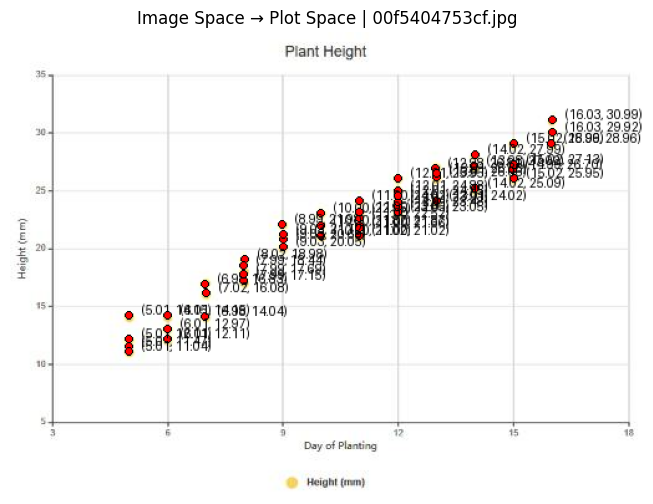

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

# Load YOLO models
tick_model = YOLO("/kaggle/input/tick-model-yolo/other/default/1/tick_best.pt")  # Detects ticks & text boxes
scatter_model = YOLO("/kaggle/input/scatter-point-detection-yolo/other/default/1/best.pt")  # Detects scatter points
plot_model = YOLO("/kaggle/input/plot-model-yolo/other/default/1/plot_best.pt")  # Detects plot area

# Load TrOCR model
processor = TrOCRProcessor.from_pretrained("/kaggle/input/trocr-model/other/default/1/trocr_model")
text_model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/trocr-model/other/default/1/trocr_model")
# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model.to(device)


# Load font for PIL (use default if DejaVuSans isn't available)
try:
    font = ImageFont.truetype("DejaVuSans.ttf", 12)  # Use a clear font
except:
    font = ImageFont.load_default()

img_path = "/kaggle/input/benetech-making-graphs-accessible/test/images/00f5404753cf.jpg"
img_file = os.path.basename(img_path)

# **Run YOLO inference for plot area**
plot_results = plot_model(img_path)
plot_x1, plot_y1, plot_x2, plot_y2 = None, None, None, None

for box in plot_results[0].boxes:
    plot_x1, plot_y1, plot_x2, plot_y2 = map(int, box.xyxy[0])  # Get bounding box of the detected plot

# Load image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image)  # Convert to PIL for better text rendering
draw = ImageDraw.Draw(pil_image)  # PIL drawing context
img_h, img_w = pil_image.size

# Run YOLO inference for ticks
tick_results = tick_model(img_path)

# Store detected elements
tick_positions_x = []  # (image_x, plot_x_value)
tick_positions_y = []  # (image_y, plot_y_value)

# Text box positions & recognized values
text_boxes_x = []  # X-axis text positions
text_boxes_y = []  # Y-axis text positions

# Process YOLO predictions
for box in tick_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=x-text, 3=y-text

    if class_id in [2, 3]:  # If it's a text box, recognize text
        cropped_text = image[y1:y2, x1:x2]
        pil_crop = Image.fromarray(cropped_text)

        # Process for TrOCR
        pixel_values = processor(pil_crop, return_tensors="pt").pixel_values.to(device)

        # Predict text
        with torch.no_grad():
            generated_ids = text_model.generate(pixel_values)
            predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        if class_id == 2:  # X-axis text
            text_boxes_x.append((x1, y1, x2, y2, predicted_text))
        elif class_id == 3:  # Y-axis text
            text_boxes_y.append((x1, y1, x2, y2, predicted_text))

    elif class_id in [0, 1]:  # Tick marks
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        if class_id == 0:  # X-axis tick
            tick_positions_x.append((center_x, center_y))
        else:  # Y-axis tick
            tick_positions_y.append((center_x, center_y))

# **Sort tick positions before matching**
tick_positions_x = sorted(tick_positions_x, key=lambda t: t[0])  # Sort X-ticks by center_x
tick_positions_y = sorted(tick_positions_y, key=lambda t: t[1], reverse=True)  # Sort Y-ticks by center_y

if(len(tick_positions_x)<len(text_boxes_x)):
    # **Insert the first Y-axis tick into X-axis ticks (fix missing first X tick)**
    tick_positions_x.insert(0, tick_positions_y[0])  # First X tick is the bottom-most Y tick

# **Extract only center_x values for x-ticks & center_y values for y-ticks**
#tick_positions_x = [x[0] for x in tick_positions_x]  # Remove center_y from X-ticks
#tick_positions_y = [y[1] for y in tick_positions_y]  # Remove center_x from Y-ticks

# **Sort text boxes before matching**
text_boxes_x = sorted(text_boxes_x, key=lambda t: t[0])  # Sort by X-position (left to right)
text_boxes_y = sorted(text_boxes_y, key=lambda t: t[1], reverse=True)  # Sort by Y-position (bottom to top)

# **Match text to nearest tick positions**
def match_ticks_to_text(tick_positions, text_boxes):
    matched_ticks = []
    used_ticks = set()  # To prevent assigning the same tick multiple times

    for text_box in text_boxes:
        x1, y1, x2, y2, text_value = text_box
        text_center_x = (x1 + x2) // 2
        text_center_y = (y1 + y2) // 2

        # Find the closest tick using Euclidean distance
        closest_tick = None
        min_distance = float("inf")

        for tick_pos in tick_positions:
            tick_x, tick_y = tick_pos
            distance = np.sqrt((text_center_x - tick_x) ** 2 + (text_center_y - tick_y) ** 2)

            if distance < min_distance and tick_pos not in used_ticks:
                min_distance = distance
                closest_tick = tick_pos

        if closest_tick:
            try:
                plot_value = float(text_value)  # Convert to float
                matched_ticks.append((closest_tick, plot_value))
                used_ticks.add(closest_tick)  # Mark tick as used
            except ValueError:
                continue  # Skip invalid text values

    return matched_ticks

# Get matched tick values
x_axis_values = match_ticks_to_text(tick_positions_x, text_boxes_x)
y_axis_values = match_ticks_to_text(tick_positions_y, text_boxes_y)

# Keep only the first number from the inner tuple in x_axis_values
x_axis_values = [(t[0][0], t[1]) for t in x_axis_values]

# Keep only the second number from the inner tuple in y_axis_values
y_axis_values = [(t[0][1], t[1]) for t in y_axis_values]

# Extract only the plot values
x_img, x_plot = zip(*x_axis_values) if x_axis_values else ([], [])
y_img, y_plot = zip(*y_axis_values) if y_axis_values else ([], [])

# **Fit linear transformation for x and y**
x_transform = np.poly1d(np.polyfit(x_img, x_plot, 1)) if len(x_img) > 1 else lambda x: x
y_transform = np.poly1d(np.polyfit(y_img, y_plot, 1)) if len(y_img) > 1 else lambda y: y

# Run YOLO inference for scatter points
scatter_results = scatter_model(img_path)

# **Extract scatter positions & transform to plot space**
scatter_plot_coords = []
for box in scatter_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # **Remove scatter points outside the detected plot area**
    if plot_x1 and plot_y1 and plot_x2 and plot_y2:
        if not (plot_x1 <= center_x <= plot_x2 and plot_y1 <= center_y <= plot_y2):
            continue  # Skip points outside the plot area

    # Convert image coordinates to plot coordinates
    plot_x = x_transform(center_x)
    plot_y = y_transform(center_y)

    scatter_plot_coords.append((plot_x, plot_y))

    # Draw scatter point with PIL
    draw.ellipse((center_x - 3, center_y - 3, center_x + 3, center_y + 3), fill="red", outline="black")

    # Add text with PIL
    draw.text((center_x + 10, center_y - 10), f"({plot_x:.2f}, {plot_y:.2f})", fill="black", font=font)

# **Sort scatter points by X-value**
scatter_plot_coords = sorted(scatter_plot_coords, key=lambda p: p[0])

# Extract x and y values
x_data_series = ";".join(str(x) for x, _ in scatter_plot_coords)
y_data_series = ";".join(str(y) for _, y in scatter_plot_coords)

# Print extracted scatter points
print(f"Image: {img_file}")
print(f"X-axis values: {x_plot}")
print(f"Y-axis values: {y_plot}")
print(f"Sorted Scatter points in plot space: {scatter_plot_coords}")
print(f"x_data_series: {x_data_series}")
print(f"y_data_series: {y_data_series}")
print("=" * 50)

# **Display results**
plt.figure(figsize=(10, 6))
plt.imshow(pil_image)
plt.title(f"Image Space → Plot Space | {img_file}")
plt.axis("off")
plt.show()

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from sklearn.linear_model import LinearRegression
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load YOLO models
tick_model = YOLO("/kaggle/working/runs/tick_train/weights/best.pt")  # Detects ticks & text boxes
scatter_model = YOLO("/kaggle/input/scatter-point-detection-yolo/other/default/1/best.pt")  # Detects scatter points

# Load TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model.to(device)

# Paths
DATASET_DIR = "/kaggle/working/tick_dataset"
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "test/images")

# Get test images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))[:5]

def fit_linear_model(pixel_values, plot_values):
    """
    Fits a linear regression model to map pixel positions to plot values.
    """
    if len(pixel_values) < 2:
        return lambda x: x  # Identity function (if not enough points)

    model = LinearRegression().fit(np.array(pixel_values).reshape(-1, 1), np.array(plot_values))
    return model.predict  # Returns a function to predict plot values

for img_file in test_images:
    img_path = os.path.join(TEST_IMAGES_DIR, img_file)

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated_img = image.copy()  # Copy for visualization
    img_h, img_w, _ = image.shape

    # Run YOLO inference for ticks
    tick_results = tick_model(img_path)

    # Store detected elements
    tick_positions_x, tick_positions_y = [], []  # (image_x, plot_x_value) & (image_y, plot_y_value)
    text_boxes_x, text_boxes_y = [], []  # X-axis & Y-axis text box positions
    recognized_texts_x, recognized_texts_y = [], []  # Recognized values

    # Process YOLO predictions
    for box in tick_results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])  # 0=x-tick, 1=y-tick, 2=x-text, 3=y-text

        if class_id in [2, 3]:  # If it's a text box, recognize text
            cropped_text = image[y1:y2, x1:x2]
            pil_image = Image.fromarray(cropped_text)

            # Process for TrOCR
            pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)

            # Predict text
            with torch.no_grad():
                generated_ids = text_model.generate(pixel_values)
                predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            try:
                text_value = float(predicted_text)  # Ensure it's a number
                if class_id == 2:  # X-axis text
                    text_boxes_x.append((x1, y1, x2, y2, text_value))
                elif class_id == 3:  # Y-axis text
                    text_boxes_y.append((x1, y1, x2, y2, text_value))
            except ValueError:
                continue  # Skip if text is not a valid number

        elif class_id in [0, 1]:  # Tick marks
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            if class_id == 0:  # X-axis tick
                tick_positions_x.append((center_x, center_y))
            else:  # Y-axis tick
                tick_positions_y.append((center_x, center_y))

    # Sort tick positions before matching
    tick_positions_x.sort(key=lambda t: t[0])  # Sort X-ticks left to right
    tick_positions_y.sort(key=lambda t: t[1], reverse=True)  # Sort Y-ticks top to bottom

    # Insert the first Y-axis tick into X-axis ticks (fix missing first X tick)
    if tick_positions_y:
        tick_positions_x.insert(0, tick_positions_y[0])

    # Extract only center_x values for x-ticks & center_y values for y-ticks
    tick_positions_x = [x[0] for x in tick_positions_x]  
    tick_positions_y = [y[1] for y in tick_positions_y]  

    # Sort text boxes before matching
    text_boxes_x.sort(key=lambda t: t[0])  # Sort by X-position
    text_boxes_y.sort(key=lambda t: t[1], reverse=True)  # Sort by Y-position

    # Match tick positions with text values
    def match_ticks_to_text(tick_positions, text_boxes):
        matched_ticks = []
        for i, tick_pos in enumerate(tick_positions):
            if i < len(text_boxes):
                _, _, _, _, text_value = text_boxes[i]
                matched_ticks.append((tick_pos, text_value))
        return matched_ticks

    x_axis_values = match_ticks_to_text(tick_positions_x, text_boxes_x)
    y_axis_values = match_ticks_to_text(tick_positions_y, text_boxes_y)

    # Extract only the plot values
    x_img, x_plot = zip(*x_axis_values) if x_axis_values else ([], [])
    y_img, y_plot = zip(*y_axis_values) if y_axis_values else ([], [])

    # Fit linear regression models for x and y axes
    x_transform = fit_linear_model(x_img, x_plot)
    y_transform = fit_linear_model(y_img, y_plot)

    # Run YOLO inference for scatter points
    scatter_results = scatter_model(img_path)

    # Convert scatter points to plot space
    scatter_plot_coords = []
    for box in scatter_results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Convert image coordinates to plot coordinates
        plot_x = x_transform([[center_x]])[0]
        plot_y = y_transform([[center_y]])[0]

        scatter_plot_coords.append((plot_x, plot_y))

        # Draw scatter point
        cv2.circle(annotated_img, (center_x, center_y), 2, (255, 0, 0), -1)
        cv2.putText(annotated_img, f"({plot_x:.2f}, {plot_y:.2f})", (center_x + 10, center_y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)

    # Sort scatter points by X-value
    scatter_plot_coords.sort(key=lambda p: p[0])

    # Print extracted scatter points
    print(f"Image: {img_file}")
    print(f"Scatter points in plot space: {scatter_plot_coords}")
    print("=" * 50)

    # Display results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(annotated_img)
    ax.set_title(f"Image Space → Plot Space | {img_file}")
    ax.axis("off")
    plt.show()


ModuleNotFoundError: No module named 'ultralytics'